Columbia University - School of Engineering and Applied Science

EAEE 4000: Machine Learning for Environmental Engineers

Final Project

Predicting Solar Power Adoption in the United States

Professor Pierre Gentine

By: Perry Flamer


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import shap
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree
import seaborn as sns
from ann_visualizer.visualize import ann_viz;



# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

!pip install shap
# Use seaborn for pairplot.
!pip install -q seaborn
!pip install -q pydot
!pip install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/EAEE4000_Machine_Learning/Individual_Project/deepsolar_tract.csv', delimiter=',',encoding='latin-1')
data.shape

(72537, 169)

In [4]:
data.sample(10)

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
52533,52533,0.0,0.0,0.000000,18163980100,NaN,Vanderburgh County,0,0,0,...,22,4,7,13,0,0,7,0,0,8.86
29014,29014,1.0,1.0,185.020480,28131020100,51190.100825,Stone County,257,662,8,...,18,2,3,1,0,0,0,0,0,9.10
24781,24781,0.0,0.0,0.000000,36005006500,30237.706612,Bronx County,284,712,12,...,36,17,16,20,0,0,40,12,7,15.32
48487,48487,26.0,24.0,608.148252,36085014700,104260.838150,Richmond County,566,625,46,...,36,17,16,20,0,0,40,12,7,15.32
31084,31084,75.0,56.0,1396.078131,8005083500,69526.151699,Arapahoe County,626,1565,7,...,50,12,15,11,0,0,10,11,0,9.82
33657,33657,116.0,104.0,3481.227672,12021010107,72199.748111,Collier County,711,873,8,...,31,6,8,9,0,0,4,20,0,10.35
45974,45974,21.0,13.0,899.329192,34031124800,71923.008850,Passaic County,449,824,7,...,27,12,13,18,0,0,9,37,1,13.69
18053,18053,354.0,259.0,7763.973250,6013355200,119388.359788,Contra Costa County,2095,1862,39,...,85,15,16,21,9,0,38,0,10,14.72
25894,25894,0.0,0.0,0.000000,42101008302,37115.375789,Philadelphia County,221,836,10,...,31,6,9,12,0,0,0,0,0,10.26
64362,64363,1.0,1.0,12.133659,53063012500,46719.026549,Spokane County,429,1194,29,...,30,8,11,19,11,0,0,8,0,7.25


In [5]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# deepsolar_tract.csv has 72537 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/EAEE4000_Machine_Learning/Individual_Project/deepsolar_tract.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'deepsolar_tract.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 169 columns


In [6]:
col_to_use = df1[["total_panel_area", "solar_panel_area_per_capita","electricity_price_overall", "average_household_income", "median_household_income", "housing_unit_median_value", "frost_days", "air_temperature", "daily_solar_radiation", "occupancy_owner_rate"]]
col_to_use = col_to_use[(col_to_use != 0).all(1)].dropna()
col_to_use.head(5)

,total_panel_area,solar_panel_area_per_capita,electricity_price_overall,average_household_income,median_household_income,housing_unit_median_value,frost_days,air_temperature,daily_solar_radiation,occupancy_owner_rate
2,64.505776,0.009253,9.53,71496.886583,63355.0,182400.0,154.0,5.4,3.76,0.776212
4,164.583303,0.011598,9.53,89135.315597,68401.0,208600.0,154.0,5.4,3.76,0.678643
6,25.299013,0.007220,9.53,41068.936170,13333.0,270800.0,154.0,5.4,3.76,0.055456
9,415.365350,0.033390,9.53,82502.407069,71591.0,173700.0,154.0,5.4,3.76,0.611329
10,532.693615,0.046631,9.53,54605.474125,41349.0,147900.0,154.0,5.4,3.76,0.420247


In [7]:
X = pd.get_dummies(col_to_use)
X.sample(10)

,total_panel_area,solar_panel_area_per_capita,electricity_price_overall,average_household_income,median_household_income,housing_unit_median_value,frost_days,air_temperature,daily_solar_radiation,occupancy_owner_rate
723,768.820541,0.050639,15.42,43885.103245,35682.0,284500.0,3.0,17.2,5.41,0.154412
105,2497.914638,0.511426,15.28,105611.951220,101689.0,295500.0,117.0,9.5,3.69,0.808209
104,1193.589950,0.183763,15.28,98011.905953,86031.0,294800.0,117.0,9.5,3.69,0.604545
202,1170.494611,0.155102,15.42,96343.116147,70489.0,664300.0,3.0,17.2,5.41,0.327273
438,268.871675,0.018066,15.42,44105.989386,22656.0,425000.0,3.0,17.2,5.41,0.056440
740,9376.274273,1.072890,15.42,137842.977924,117379.0,647000.0,9.0,17.2,5.35,0.887454
63,390.153457,0.151678,15.28,58844.395280,53906.0,163900.0,117.0,9.5,3.69,0.536703
116,1098.770791,0.157553,15.42,62724.734694,47178.0,458100.0,3.0,17.2,5.41,0.544444
305,788.566657,0.228835,15.42,78643.172691,55100.0,457100.0,3.0,17.2,5.41,0.460894
421,72.482208,0.021003,15.42,36890.446429,23750.0,483300.0,3.0,17.2,5.41,0.014694


In [8]:
# Read the data 
# Prepare X and Y 
X = pd.get_dummies(col_to_use)
X.drop(["solar_panel_area_per_capita", "total_panel_area"], inplace=True, axis=1)
y = col_to_use["solar_panel_area_per_capita"]
X.head(5)

,electricity_price_overall,average_household_income,median_household_income,housing_unit_median_value,frost_days,air_temperature,daily_solar_radiation,occupancy_owner_rate
2,9.53,71496.886583,63355.0,182400.0,154.0,5.4,3.76,0.776212
4,9.53,89135.315597,68401.0,208600.0,154.0,5.4,3.76,0.678643
6,9.53,41068.936170,13333.0,270800.0,154.0,5.4,3.76,0.055456
9,9.53,82502.407069,71591.0,173700.0,154.0,5.4,3.76,0.611329
10,9.53,54605.474125,41349.0,147900.0,154.0,5.4,3.76,0.420247


In [9]:
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
# Fit the Model
model.fit(X, y)

[16:51:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.001, max_depth=10, n_estimators=1000)

In [10]:
# load JS visualization code to notebook
shap.initjs()

In [11]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
shap_values = explainer.shap_values(X, check_additivity=False)

In [12]:
shap.initjs()
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

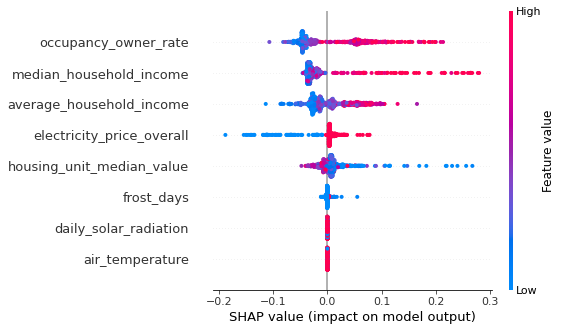

In [13]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

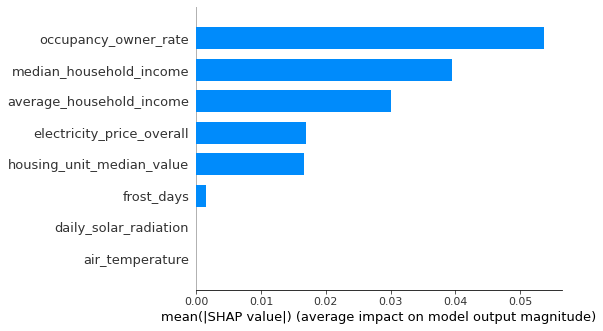

In [14]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type="bar")

End of Shapley Value Code

Below is Regression from keras example code
https://www.tensorflow.org/tutorials/keras/regression

2.9.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 1000 rows and 169 columns
[[     0.41   62574.008     15.306 523408.06 ]]
1/1 [==============================] - 0s 79ms/step


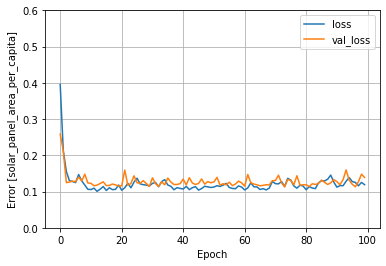

In [15]:
# Code for Linear Regression and DNN 
# This cell also contains the pipeline to access the dataset and clean it

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')
nRowsRead = 1000 # specify 'None' if want to read whole file
# deepsolar_tract.csv has 72537 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/EAEE4000_Machine_Learning/Individual_Project/deepsolar_tract.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'deepsolar_tract.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

col_to_use = df1[["total_panel_area", "solar_panel_area_per_capita","electricity_price_overall", "average_household_income", "median_household_income", "housing_unit_median_value", "frost_days", "air_temperature", "daily_solar_radiation", "occupancy_owner_rate"]]
num_nans = col_to_use.isnull().sum()
col_to_use = col_to_use[(col_to_use != 0).all(1)].dropna()
raw_dataset = col_to_use[["solar_panel_area_per_capita","occupancy_owner_rate", "median_household_income", "electricity_price_overall", "housing_unit_median_value"]]
raw_dataset.head(5)

dataset = raw_dataset.copy()
dataset.tail()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Used to understand the training dataset
# train_dataset.describe().transpose()

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('solar_panel_area_per_capita')
test_labels = test_features.pop('solar_panel_area_per_capita')

train_labels.head()

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

first = np.array(train_features[:1])


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.6])
  plt.xlabel('Epoch')
  plt.ylabel('Error [solar_panel_area_per_capita]')
  plt.legend()
  plt.grid(True)

test_results = {}

  
# Linear regression with multiple inputs
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
linear_model.predict(train_features[:10])
linear_model.layers[1].kernel
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.1), loss='mean_absolute_error')

# %%time
history = linear_model.fit(train_features,train_labels, epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)



plot_loss(history)

# For storing the characteristics of the NN for later access
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


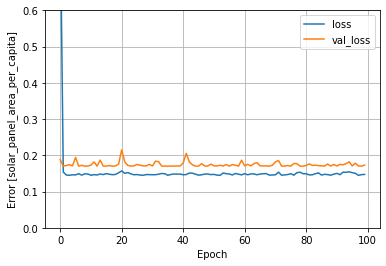

In [16]:
# Regression with a deep neural network (DNN)
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                # optimizer=tf.keras.optimizers.Adam(0.001))
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
  return model
  
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

# %%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
# Creating an figure of the Neural Network
# plot_model(dnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

4/4 [==============================] - 0s 2ms/step


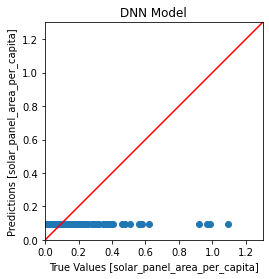

In [17]:
# Make predictions
test_predictions_DNN_model = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_DNN_model)
plt.xlabel('True Values [solar_panel_area_per_capita]')
plt.ylabel('Predictions [solar_panel_area_per_capita]')
plt.title('DNN Model')
lims = [0, 1.3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, "r-")


4/4 [==============================] - 0s 2ms/step


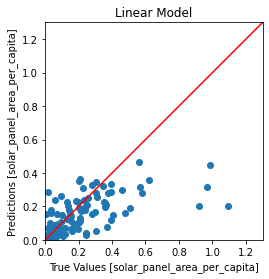

In [18]:
# Make predictions
test_predictions_linear_model = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_linear_model)
plt.xlabel('True Values [solar_panel_area_per_capita]')
plt.ylabel('Predictions [solar_panel_area_per_capita]')
plt.title('Linear Model')
lims = [0, 1.3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, "r-")


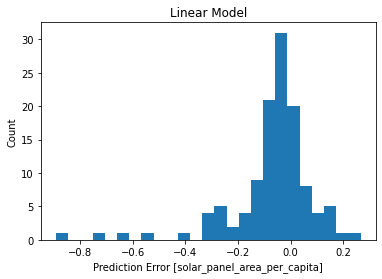

In [19]:
error = test_predictions_linear_model - test_labels
plt.hist(error, bins=25)
plt.title('Linear Model')
plt.xlabel('Prediction Error [solar_panel_area_per_capita]')
_ = plt.ylabel('Count')

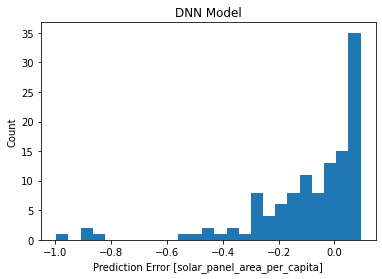

In [20]:
error = test_predictions_DNN_model - test_labels
plt.hist(error, bins=25)
plt.title('DNN Model')
plt.xlabel('Prediction Error [solar_panel_area_per_capita]')
_ = plt.ylabel('Count')

7/7 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.8643
[0.32945093512535095, 0.8643215894699097]


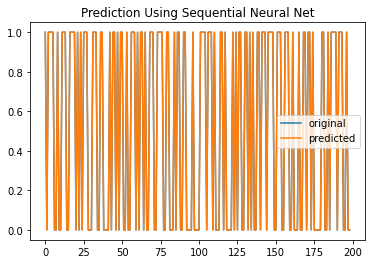

In [21]:
# Below adapted from https://www.bmc.com/blogs/deep-learning-neural-network-tutorial-keras/**



shap_col = col_to_use[["occupancy_owner_rate", "median_household_income", "electricity_price_overall", "housing_unit_median_value"]]
x = shap_col.to_numpy()

# setting all values above the median to 1 and values below the median to 0
abov_median = col_to_use["solar_panel_area_per_capita"] >= (col_to_use["solar_panel_area_per_capita"].median())
abov_median2 = pd.DataFrame({'solar_panel_area_per_capita':abov_median.values})
y = abov_median2.to_numpy()

# y = col_to_use["solar_panel_area_per_capita"].to_numpy()

features = shap_col.to_numpy()
labels = y
X=features
y=np.ravel(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(4,)))
model.add(Dense(8, activation='sigmoid'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
# optimizer='sgd',
optimizer='adam',
metrics=['accuracy'])
model.fit(X_train, y_train,epochs=100, batch_size=1, verbose=0)

y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test, label="predicted")
plt.title("Prediction Using Sequential Neural Net")
plt.legend()
plt.show()

# Creating figures of the Neural Net models
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
ann_viz(model, view=True, filename= "network_model. gv", title="DNN for Binary Classification Network")